In [12]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/lineesha/Documents/GitHub/LLM-Loan-Confidence-Prediction/data/unemployment


In [16]:
import pandas as pd

demographic_data = pd.read_csv('../demographic_data.csv')
difference_data = pd.read_csv('../cred_score/merged_data_llama-3.3-70b-versatile.csv')

print('read')

read


In [17]:
print("Demographic columns:\n", demographic_data.columns.tolist())
print("\nDifference columns:\n", difference_data.columns.tolist())

Demographic columns:
 ['County', 'State', 'State FIPS Code', 'County FIPS Code', 'fips', 'Total Population', 'Male Population', 'Female Population', 'Total Race Responses', 'White Alone', 'Black or African American Alone', 'Hispanic or Latino', 'Unnamed: 12', 'White Population', 'Black Population', 'Hispanic/Latino Population', 'Unnamed: 16', 'Unnamed: 17', 'Total']

Difference columns:
 ['county_fips', 'county', 'predicted_credit_score', 'loan_confidence', 'error', 'FIPS', 'credit_score', 'par_state', 'par_county', 'county_name', 'kid_race', 'Difference']


In [19]:
merged = pd.merge(
    difference_data,
    demographic_data,
    left_on='county_fips',
    right_on='fips',
    how='inner'
)

In [21]:
#Number of counties with underestimated credit scores and lower-than-avg white populations 
merged['difference'] = merged['predicted_credit_score'] - merged['credit_score']

white_avg = 0.598

underestimated = merged[
    (merged['difference'] < 0) &   #predicted < actual
    (merged['White Population'] < white_avg)
]

underestimates = merged[(merged['difference'] < 0)]
num_underestimates = len(underestimates)
print(num_underestimates)

print("Total Counties:", len(merged))
print("Number of underestimated counties with above-average White population:", len(underestimated))
print("Out of total underestimated counties:", num_underestimates)
print("Percentage:", len(underestimated) / num_underestimates * 100)

851
Total Counties: 3204
Number of underestimated counties with above-average White population: 235
Out of total underestimated counties: 851
Percentage: 27.614571092831962


In [22]:
#Number of counties with overestimated credit score and higher-than-avg white populations 
merged['difference'] = merged['predicted_credit_score'] - merged['credit_score']

white_avg = 0.598

overestimated = merged[
    (merged['difference'] > 0) &   # predicted < actual
    (merged['White Population'] > white_avg)
]

overestimates = merged[(merged['difference'] > 0)]
num_overestimates = len(overestimates)

print("Total Counties:", len(merged))
print("Number of overestimated counties with below-average White population:", len(overestimated))
print("Out of total overestimated counties:", num_overestimates)
print("Percentage:", len(overestimated) / num_overestimates * 100)


Total Counties: 3204
Number of overestimated counties with below-average White population: 2020
Out of total overestimated counties: 2340
Percentage: 86.32478632478633


In [23]:
#counties with higher than avg white population
higher_white = merged[(merged['White Population']> white_avg)]
print("Percent counties w/ higher than avg white population:", len(higher_white)/len(merged)*100)

lower_white = merged[(merged['White Population']< white_avg)]
print("Percent counties w/ lower than avg white population:", len(lower_white)/len(merged)*100)



Percent counties w/ higher than avg white population: 82.58426966292134
Percent counties w/ lower than avg white population: 17.415730337078653


In [27]:
##finding proportion of each population

print(len(underestimated)/len(lower_white))
print(len(overestimated)/len(higher_white))

0.4211469534050179
0.763416477702192


In [28]:
corr = merged["predicted_credit_score"].corr(merged["White Population"])
print("Correlation between % White population and predicted credit score:", corr)

Correlation between % White population and predicted credit score: 0.26411872393240304


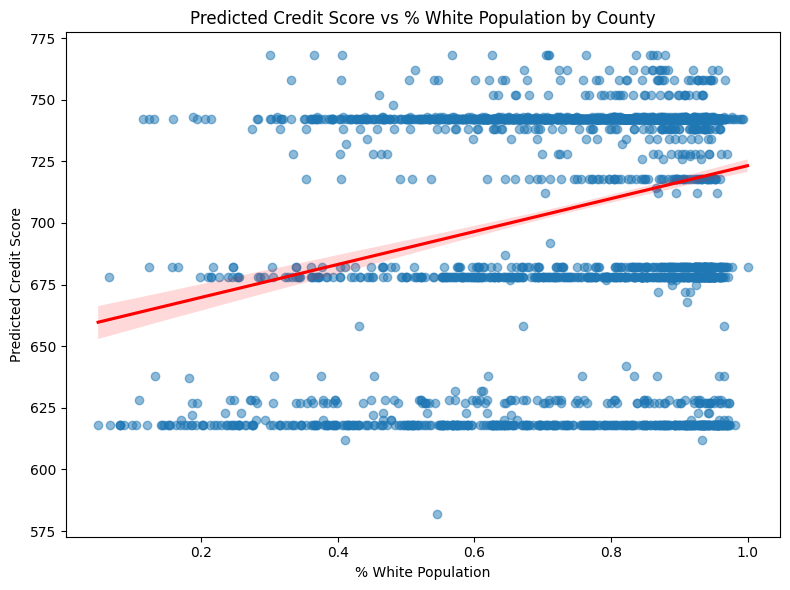

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(
    x="White Population",
    y="predicted_credit_score",
    data=merged,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)

plt.title("Predicted Credit Score vs % White Population by County")
plt.xlabel("% White Population")
plt.ylabel("Predicted Credit Score")
plt.tight_layout()
plt.show()